In [ ]:
'''
q-learner
    -policy
    -value function
    -update()
    -move()
    
portfolio
    -cash
    -assets
    -orderHistory
        -orders[{time, asset, action, amount, value}]
        -show()
    -show()

Notes
    -sharpe ratio = risk/reward
    -volatility = standard deviation
    -momentum = price change over time = (data[n] / data[n-t]) - 1
    -bollinger bands
    

Dyna Q:
http://www-anw.cs.umass.edu/~barto/courses/cs687/Chapter%209.pdf
'''


In [1]:
##########################################
# Setup project path to use 
# data_exploration.py and ml_modeling.py
##########################################

import os
import sys

# Set project path using platform/environment agnostic language
parent_project_name = 'Python_Notebooks_For_Machine_Learning'
path = os.getcwd()
parent_project_name = path[0: path.index(parent_project_name) + len(parent_project_name)]

# Import common.py library
sys.path.insert(0, parent_project_name + os.sep + 'common')

import financial_modeling as fin

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Read data
filePath = 'data/spy_5yrs.csv'
# data = fin.get_data(filePath,)
data = pd.read_csv(filePath)

# Remove first row (bad data)
data = data.iloc[1:]
data.index = data['date']

# Sort data by index (ascending)
data = data.loc[sorted(data.index)]

# Take only the daily close data and normalize it
data = pd.DataFrame(data['close'])
data['close'] = data['close']/data['close'].iloc[0]
data.head()

,close
date,
2012-12-10,1.000000
2012-12-11,1.006808
2012-12-12,1.007300
2012-12-13,1.001123
2012-12-14,0.997403


In [3]:
def get_rolling_mean(values, window):
    """Return rolling mean of given values, using specified window size."""
    return values.rolling(center=False, window=window).mean()


def get_rolling_std(values, window):
    """Return rolling standard deviation of given values, using specified window size."""
    return values.rolling(center=False, window=window).std()


def get_bollinger_bands(rm, rstd, b=2):
    """Return upper and lower Bollinger Bands."""
    upper_band = rm + b*rstd
    lower_band = rm - b*rstd
    return upper_band, lower_band

def get_momentum(values, window):
    momentum = values - values.shift(window)
    return momentum

In [4]:
# Define state features
window = 20

data['rm'] = get_rolling_mean(data['close'], window)
data['rstd'] = get_rolling_std(data['close'], window)
data['ubb_1.5'], data['lbb_1.5'] = get_bollinger_bands(data['rm'],data['rstd'],b=1.5)
data['ubb_2.0'], data['lbb_2.0'] = get_bollinger_bands(data['rm'],data['rstd'],b=2)
data['ubb_2.5'], data['lbb_2.5'] = get_bollinger_bands(data['rm'],data['rstd'],b=2.5)
data['mom_2'] = get_momentum(data['close'], window=2)
data['rstd_5'] = get_rolling_std(data['close'], 2)

In [10]:
data

,close,rm,rstd,ubb_1.5,lbb_1.5,ubb_2.0,lbb_2.0,ubb_2.5,lbb_2.5,mom_2,rstd_5
date,,,,,,,,,,,
2012-12-10,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-11,1.006808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004814
2012-12-12,1.007300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007300,0.000347
2012-12-13,1.001123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005685,0.004368
2012-12-14,0.997403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009897,0.002630
2012-12-17,1.009125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008002,0.008289
2012-12-18,1.020355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022952,0.007941
2012-12-19,1.012775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003650,0.005360
2012-12-20,1.018600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001755,0.004119


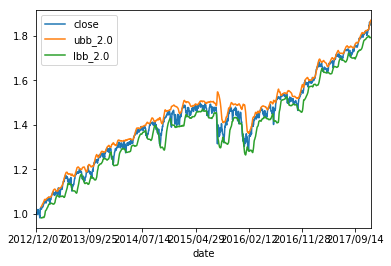

In [50]:
# Plot data
data[['close','ubb_2.0','lbb_2.0']].plot()
plt.show()

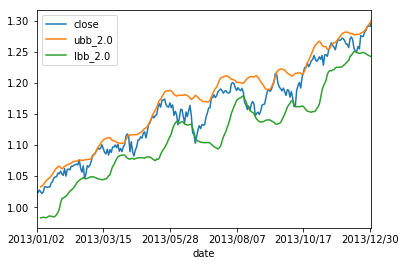

In [51]:
# Plot first 200 data points
data.loc['2013-01-01':'2014-01-01'][['close','ubb_2.0','lbb_2.0']].plot()

In [5]:
# Transform data to have states with fewer posible values
# state_df = pd.DataFrame(data={
#     'above_ubb_1.5': data['close'] > data['ubb_1.5'],
#     'above_ubb_2.0': data['close'] > data['ubb_2.0'],
#     'above_ubb_2.5': data['close'] > data['ubb_2.5'],
#     'below_lbb_1.5': data['close'] > data['lbb_1.5'],
#     'below_lbb_2.0': data['close'] > data['lbb_2.0'],
#     'below_lbb_2.5': data['close'] > data['lbb_2.5'],
#     'momentum': pd.Series(['up' if x>0 else 'down' if x<0 else 'same' for x in data['mom_2']],index=data.index)
# })

state_df = pd.DataFrame(data={
    'bb_.5': np.floor(((data['close'] - data['rm']) / data['rstd']) * 2) / 2, # Floors rolling std to nearest half
    'momentum': pd.Series(['up' if x>0 else 'down' if x<0 else 'same' for x in data['mom_2']],index=data.index),
    'hasCash': None,
    'hasStock': None
})
state_df

,bb_.5,hasCash,hasStock,momentum
date,,,,
2012-12-10,NaN,None,None,same
2012-12-11,NaN,None,None,same
2012-12-12,NaN,None,None,up
2012-12-13,NaN,None,None,down
2012-12-14,NaN,None,None,down
2012-12-17,NaN,None,None,up
2012-12-18,NaN,None,None,up
2012-12-19,NaN,None,None,up
2012-12-20,NaN,None,None,down


In [12]:
data

,close,rm,rstd,ubb_1.5,lbb_1.5,ubb_2.0,lbb_2.0,ubb_2.5,lbb_2.5,mom_2,rstd_5
date,,,,,,,,,,,
2012-12-10,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-11,1.006808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004814
2012-12-12,1.007300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007300,0.000347
2012-12-13,1.001123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005685,0.004368
2012-12-14,0.997403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009897,0.002630
2012-12-17,1.009125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008002,0.008289
2012-12-18,1.020355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022952,0.007941
2012-12-19,1.012775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003650,0.005360
2012-12-20,1.018600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001755,0.004119


In [ ]:
'''
State: ubb, lbb, close, etc
Action: buy (if cash > 0), sell (if stock > 0), hold
Reward: cummulative portfolio gain
    Reward function: (shares * close) + cash
Discount: .9 (close to 1 to prioritize long-term goals but still force 
    incentive to do something other than hold)

initialize q_table w/ random values
initial state = data in initial date
choose action based on greed or random event

q[s][a] = q[s][a] + alpha[r + g*max_a'(q[s'][a']) - q[s][a]]
'''

In [93]:
state_df.iloc[20:25]

,bb_.5,hasCash,hasStock,momentum
date,,,,
2013/01/08,1.0,None,None,down
2013/01/09,1.0,None,None,down
2013/01/10,1.5,None,None,up
2013/01/11,1.0,None,None,up
2013/01/14,1.0,None,None,down


In [121]:
d = {
    "a":{
        "aa":1,
        "bb":2
    },
    "b":{
        "ba":3,
        "bb":2
    }
}
for key in d:
    print(max(d[key], key=d[key].get))

bb
ba


In [124]:
df = pd.DataFrame(d)
print(df)

      a    b
aa  1.0  NaN
ba  NaN  3.0
bb  2.0  2.0


In [7]:
reward_df = data[['close']]
reward_df

,close
date,
2012-12-10,1.000000
2012-12-11,1.006808
2012-12-12,1.007300
2012-12-13,1.001123
2012-12-14,0.997403
2012-12-17,1.009125
2012-12-18,1.020355
2012-12-19,1.012775
2012-12-20,1.018600


In [23]:
reward_df.iloc[1]['close']

1.0068084578731771

In [19]:
import json
a = []
b = []
for _ in range(1000):
    for index, row in state_df.iloc[20:25].iterrows():
        a.append(row.to_dict())
        b.append(json.dumps(row.to_dict()))

In [20]:
%%timeit -n 1000
for d in a:
    json.dumps(d)

1000 loops, best of 3: 19.3 ms per loop


In [21]:
%%timeit -n 1000
for s in b:
    json.loads(s)

1000 loops, best of 3: 17.4 ms per loop


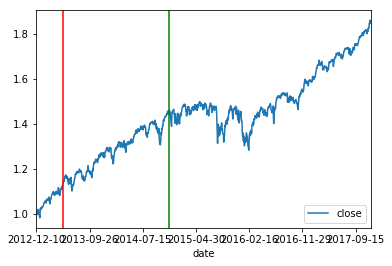

In [39]:
ax = reward_df.plot()
plt.axvline(500, color='g')
plt.axvline(100, color='r')
plt.show()

In [41]:
reward_df.loc['2013-01-01':'2016-12-31']

,close
date,
2013-01-02,1.025198
2013-01-03,1.022882
2013-01-04,1.027374
2013-01-07,1.024567
2013-01-08,1.021619
2013-01-09,1.024216
2013-01-10,1.032358
2013-01-11,1.032288
2013-01-14,1.031586


In [42]:
reward_df.loc['2017-01-01':'2017-12-31']

,close
date,
2017-01-03,1.580964
2017-01-04,1.590370
2017-01-05,1.589106
2017-01-06,1.594792
2017-01-09,1.589528
2017-01-10,1.589528
2017-01-11,1.594020
2017-01-12,1.590019
2017-01-13,1.593669
